BerkeleyX: Data8.2x

Foundations of Data Science: Inferential Thinking by Resampling

In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Lec 8.1 Introduction

A/B Testing

In [2]:
baby = Table.read_table('../../data/baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
# we are interested just in the weight of the baby and if the mother is a smoker
smoking_and_birthweight = baby.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


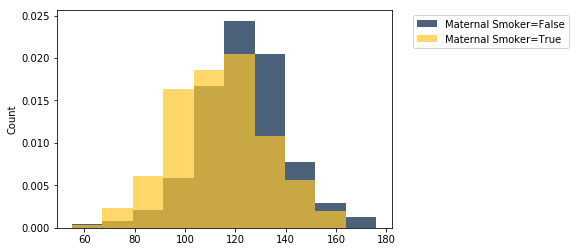

In [5]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker', normed=None, density=True)

In [6]:
# let's compare the mean of the two groups
means_tbl = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_tbl

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [7]:
means = means_tbl.column(1)
observed_difference = means.item(0) - means.item(1)
observed_difference

9.266142572024918

Lec 8.2 Hypotheses and Statistic

Is the difference between the two groups due to chance?

- group A: smokers
- group B: non smokers
- statistics: difference between average weights

Null: no difference

If Null is true, we can shuffle the sample and then assign assign randomly to smoker or non-smoker without changing the result.

Lec 8.3 Performing the Test

In [8]:
# working just on weights
weights = smoking_and_birthweight.select('Birth Weight')
weights

Birth Weight
120
113
128
108
136
138
132
120
143
140


In [9]:
# take a sample sized like the population - just shuffle it
weights.sample(with_replacement=False)

Birth Weight
104
173
134
120
128
91
128
131
112
118


In [10]:
shuffled_weights = weights.sample(with_replacement=False).column(0)
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Birth Weight', shuffled_weights
)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Birth Weight
False,120,96
False,113,101
True,128,124
True,108,117
False,136,148
False,138,111
False,132,133
False,120,143
True,143,96
False,140,127


In [11]:
# we get quite a smaller difference
original_and_shuffled.group('Maternal Smoker', np.average)

Maternal Smoker,Birth Weight average,Shuffled Birth Weight average
False,123.085,119.829
True,113.819,118.891


In [12]:
group_labels = baby.select('Maternal Smoker')
group_labels

Maternal Smoker
False
False
True
True
False
False
False
False
True
False


In [13]:
# array of shuffled weights
shuffled_weights = weights.sample(with_replacement=False).column(0)

# table with shuffled weights assigned to group labels
shuffled_tbl = group_labels.with_column('Shuffled Weight', shuffled_weights)

# array of means of the two groups
means = shuffled_tbl.group('Maternal Smoker', np.average).column(1)

# difference between means of the two groups
new_difference = means.item(0) - means.item(1)
new_difference

-0.3530843883785053

In [14]:
iterations = 5_000

differences = np.empty(iterations)

for i in np.arange(iterations):
    shuffled_weights = weights.sample(with_replacement = False).column(0)
    shuffled_tbl = group_labels.with_column('Shuffled Weight', shuffled_weights)
    means = shuffled_tbl.group('Maternal Smoker', np.average).column(1)
    differences[i] = means.item(0) - means.item(1)

9.266142572024918

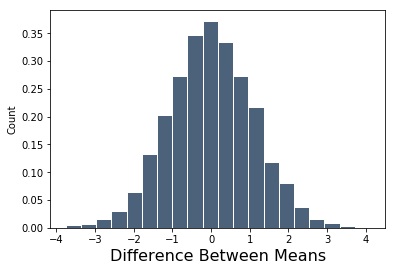

In [15]:
Table().with_column('Difference Between Means', differences).hist(
    bins=20, ec='w', normed=None, density=True)

# the observed difference is far out the results following the Null Hypothesis
observed_difference

Lec 8.4 Deflategate Introduction

In [16]:
football = Table.read_table('../../data/deflategate.csv')
football.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


In [17]:
# assuming honesty from Blakeman and Prioleau, combine their measures
football = football.drop(1, 2).with_column(
    'Combined', (football.column(1) + football.column(2)) / 2
)
football

Team,Combined
Patriots,11.65
Patriots,11.025
Patriots,11.325
Patriots,10.85
Patriots,11.275
Patriots,11.775
Patriots,12.075
Patriots,11.325
Patriots,11.15
Patriots,10.7


In [18]:
# initial pressure was 12.5 for Patriots balls and 13 for Colts ones
np.ones(5)
start = np.append(12.5 * np.ones(11), 13 * np.ones(4))
start

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

In [19]:
drops = start - football.column(1)
drops

array([0.85 , 1.475, 1.175, 1.65 , 1.225, 0.725, 0.425, 1.175, 1.35 ,
       1.8  , 1.375, 0.475, 0.475, 0.275, 0.65 ])

In [20]:
football = football.select('Team').with_column(
    'Drop', drops
)
football.show()

Team,Drop
Patriots,0.85
Patriots,1.475
Patriots,1.175
Patriots,1.65
Patriots,1.225
Patriots,0.725
Patriots,0.425
Patriots,1.175
Patriots,1.35
Patriots,1.8


In [21]:
# check the average difference in pressure drop
means_tbl = football.group('Team', np.average)
means_tbl

Team,Drop average
Colts,0.46875
Patriots,1.20227


In [22]:
means = means_tbl.column(1)
observed_difference = means.item(0) - means.item(1)
observed_difference

-0.733522727272728

Lec 8.5 Deflategate Testing

Null Hypothesis: difference due to random sampling

In [23]:
group_labels = football.select('Team')
drop_tbl = football.select('Drop')

In [24]:
# calculate a random difference
shuffled_drops = drop_tbl.sample(with_replacement=False).column(0)
shuffled_tbl = group_labels.with_column('Shuffled Drop', shuffled_drops)
means = shuffled_tbl.group('Team', np.average).column(1)
means.item(0) - means.item(1)

-0.34147727272727346

In [25]:
iterations = 20_000
differences = np.empty(iterations)

for i in range(iterations):
    shuffled_drops = drop_tbl.sample(with_replacement=False).column(0)
    shuffled_tbl = group_labels.with_column('Shuffled Drop', shuffled_drops)
    means = shuffled_tbl.group('Team', np.average).column(1)
    differences[i] = means.item(0) - means.item(1)

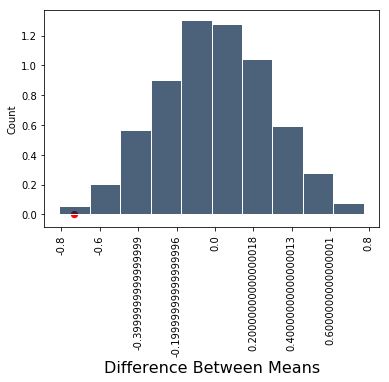

In [26]:
Table().with_column('Difference Between Means', differences).hist(
    ec='w', normed=None, density=True)
plt.scatter(observed_difference, 0, color='red', s=40);

In [27]:
# P-value is quite small
np.count_nonzero(differences <= observed_difference) / 20000

0.0027